In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torchvision
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor
from torchvision.transforms import functional as F
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import matplotlib.pyplot as plt


# 数据集类
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, class_names=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))
        self.class_names = class_names

        # 打印图像和标注文件列表长度
        print(f"Number of images: {len(self.imgs)}")
        print(f"Number of annotations: {len(self.annotations)}")

        # 检查图像文件和标注文件是否一致
        assert len(self.imgs) == len(self.annotations), "Number of images and annotations do not match"


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        ann_path = os.path.join(self.root, "Annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            label = self.class_names.index(obj.find("name").text)
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor(idx)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# 数据变换
class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

# 模型定义
def get_model(num_classes):

    weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 工具函数
def collate_fn(batch):
    return tuple(zip(*batch))

def convert_to_coco_format(dataset, results):
    coco_data = []
    ann_id = 0
    for img_id, output in enumerate(results):
        if len(output["boxes"]) == 0:
            continue
        boxes = output["boxes"]
        scores = output["scores"]
        labels = output["labels"]
        for box, score, label in zip(boxes, scores, labels):
            x_min, y_min, x_max, y_max = box.tolist()
            width = x_max - x_min
            height = y_max - y_min
            coco_data.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": int(label.item()),
                "bbox": [x_min, y_min, width, height],
                "score": float(score.item())
            })
            ann_id += 1
    return coco_data

def get_ground_truth(dataset):
    coco_data = []
    ann_id = 0
    size_counts = {'small': 0, 'medium': 0, 'large': 0}
    for img_id in range(len(dataset)):
        img, target = dataset[img_id]
        boxes = target["boxes"].tolist()
        labels = target["labels"].tolist()
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            area = width * height
            if area < 95**2:
                size_counts['small'] += 1
            elif area < 122**2:
                size_counts['medium'] += 1
            else:
                size_counts['large'] += 1

            coco_data.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": int(label),
                "bbox": [x_min, y_min, width, height],
                "iscrowd": 0,
                "area": area
            })
            ann_id += 1
    print(f"Size counts: {size_counts}")
    return coco_data, size_counts

def evaluate(model, data_loader, dataset, device, class_names):
    model.eval()
    results = []
    val_loss = 0
    val_box_loss = 0
    val_class_loss = 0

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

        for images, targets in progress_bar:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Skip the batch if targets are empty
            if all(len(t['boxes']) == 0 for t in targets):
                continue

            outputs = model(images)
            for target, output in zip(targets, outputs):
                output["image_id"] = target["image_id"].item()
                results.append(output)

            # Manually compute loss
            model.train()  # Temporarily set the model to training mode to calculate losses
            loss_dict = model(images, targets)
            model.eval()  # Switch back to evaluation mode
            val_box_loss += loss_dict['loss_box_reg'].item()
            val_class_loss += loss_dict['loss_classifier'].item()
            val_loss += sum(loss for loss in loss_dict.values()).item()

    coco_gt, size_counts = get_ground_truth(dataset)

    coco = COCO()
    coco.dataset = {'annotations': coco_gt, 'images': [], 'categories': [{'id': i, 'name': name} for i, name in enumerate(class_names, 1)]}
    for i in range(len(dataset)):
        coco.dataset['images'].append({'id': i})
    coco.createIndex()

    coco_dt = convert_to_coco_format(dataset, results)
    coco_dt = coco.loadRes(coco_dt)
    coco_eval = COCOeval(coco, coco_dt, 'bbox')

    # 设置areaRng，但只评估实际存在的目标大小类别
    coco_eval.params.areaRng = [[0, 1e5**2], [0, 95**2], [95**2, 122**2], [122**2, 1e5**2]]
    coco_eval.params.areaRngLbl = ['all', 'small', 'medium', 'large']

    coco_eval.params.iouThrs = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # 提取评估结果
    precision = coco_eval.stats[0]  # mAP@0.5:0.95
    mAP_50 = coco_eval.stats[1]  # mAP@0.5
    recall = coco_eval.stats[8]  # AR@1 (maxDets=1)

    # 提取分类评估结果
    precisions = coco_eval.eval['precision']
    recalls = coco_eval.eval['recall']

    class_ap_50_95 = []
    class_ap_50 = []
    class_recall = []


    for i, class_name in enumerate(class_names[1:], 1):  # Skip background
        print(f"\nEvaluating class: {class_name}\n")
        coco_eval.params.catIds = [i]
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        class_ap_50_95.append(coco_eval.stats[0])  # mAP@0.5:0.95
        class_ap_50.append(coco_eval.stats[1])  # mAP@0.5
        class_recall.append(coco_eval.stats[8])  # Recall

    avg_val_loss = val_loss / len(data_loader)
    avg_val_box_loss = val_box_loss / len(data_loader)
    avg_val_class_loss = val_class_loss / len(data_loader)

    return avg_val_loss, avg_val_box_loss, avg_val_class_loss, precision, mAP_50, recall, class_ap_50_95, class_ap_50, class_recall

# 训练函数
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    epoch_loss = 0

    box_loss_sum = 0
    class_loss_sum = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Skip the batch if targets are empty
        if all(len(t['boxes']) == 0 for t in targets):
            continue

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        box_loss_sum += loss_dict['loss_box_reg'].item()
        class_loss_sum += loss_dict['loss_classifier'].item()
        progress_bar.set_postfix(loss=losses.item())

    avg_loss = epoch_loss / len(data_loader)
    avg_box_loss = box_loss_sum / len(data_loader)
    avg_class_loss = class_loss_sum / len(data_loader)

    print(f"Epoch [{epoch + 1}], Total Loss: {avg_loss:.4f}, Box Loss: {avg_box_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

    return avg_loss, avg_box_loss, avg_class_loss

# 绘制结果图
def plot_results(results):
    epochs = range(1, len(results['train_losses']) + 1)

    plt.figure(figsize=(12, 3))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, results['train_losses'], label='Train Loss')
    plt.plot(epochs, results['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs, results['train_box_losses'], label='Train Box Loss')
    plt.plot(epochs, results['val_box_losses'], label='Validation Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Loss')
    plt.title('Train and Validation Box Loss')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs, results['train_class_losses'], label='Train Class Loss')
    plt.plot(epochs, results['val_class_losses'], label='Validation Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Class Loss')
    plt.title('Train and Validation Class Loss')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, results['mAP_50_95s'], label='mAP@0.5:0.95')
    plt.plot(epochs, results['mAP_50s'], label='mAP@0.5')
    plt.plot(epochs, results['recalls'], label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Evaluation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_results.png')



Number of images: 198
Number of annotations: 198


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1], Total Loss: 0.4035, Box Loss: 0.0934, Class Loss: 0.2473


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [2], Total Loss: 0.2326, Box Loss: 0.1192, Class Loss: 0.0942


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [3], Total Loss: 0.2602, Box Loss: 0.1541, Class Loss: 0.0980


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [4], Total Loss: 0.2471, Box Loss: 0.1569, Class Loss: 0.0844


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [5], Total Loss: 0.2303, Box Loss: 0.1511, Class Loss: 0.0746


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [6], Total Loss: 0.2039, Box Loss: 0.1322, Class Loss: 0.0681


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [7], Total Loss: 0.1739, Box Loss: 0.1125, Class Loss: 0.0580


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [8], Total Loss: 0.1548, Box Loss: 0.0958, Class Loss: 0.0564


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.607
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [9], Total Loss: 0.1263, Box Loss: 0.0792, Class Loss: 0.0451


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [10], Total Loss: 0.1086, Box Loss: 0.0686, Class Loss: 0.0384


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [11], Total Loss: 0.0892, Box Loss: 0.0565, Class Loss: 0.0312


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [12], Total Loss: 0.0860, Box Loss: 0.0577, Class Loss: 0.0269


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [13], Total Loss: 0.0754, Box Loss: 0.0513, Class Loss: 0.0229


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [14], Total Loss: 0.0651, Box Loss: 0.0448, Class Loss: 0.0192


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [15], Total Loss: 0.0570, Box Loss: 0.0388, Class Loss: 0.0170


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [16], Total Loss: 0.0479, Box Loss: 0.0326, Class Loss: 0.0145


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [17], Total Loss: 0.0491, Box Loss: 0.0338, Class Loss: 0.0145


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.791
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.439
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [18], Total Loss: 0.0496, Box Loss: 0.0347, Class Loss: 0.0143


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [19], Total Loss: 0.0457, Box Loss: 0.0307, Class Loss: 0.0143


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.783
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [20], Total Loss: 0.0450, Box Loss: 0.0310, Class Loss: 0.0134


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.782
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [21], Total Loss: 0.0398, Box Loss: 0.0266, Class Loss: 0.0126


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.791
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [22], Total Loss: 0.0410, Box Loss: 0.0279, Class Loss: 0.0124


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [23], Total Loss: 0.0391, Box Loss: 0.0259, Class Loss: 0.0126


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [24], Total Loss: 0.0429, Box Loss: 0.0304, Class Loss: 0.0120


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [25], Total Loss: 0.0373, Box Loss: 0.0252, Class Loss: 0.0117


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [26], Total Loss: 0.0335, Box Loss: 0.0220, Class Loss: 0.0110


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [27], Total Loss: 0.0336, Box Loss: 0.0225, Class Loss: 0.0106


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.793
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.439
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [28], Total Loss: 0.0301, Box Loss: 0.0187, Class Loss: 0.0110


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [29], Total Loss: 0.0303, Box Loss: 0.0197, Class Loss: 0.0102


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.816
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [30], Total Loss: 0.0306, Box Loss: 0.0200, Class Loss: 0.0102


Size counts: {'small': 17, 'medium': 14, 'large': 12}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

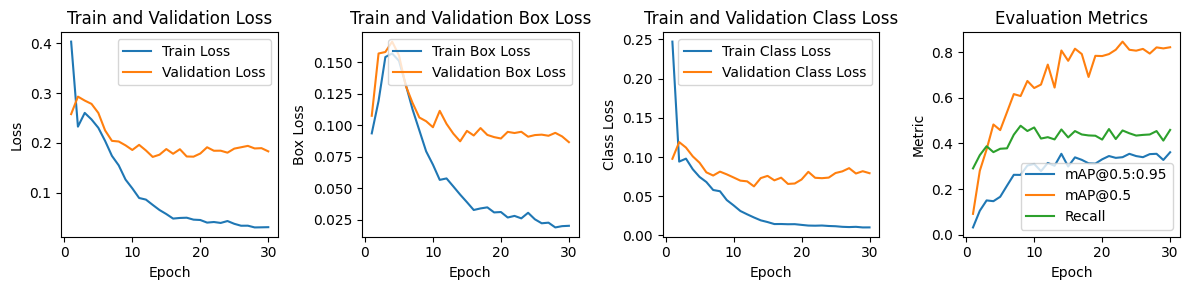

In [ ]:
# 主函数
if __name__ == "__main__":
    # 加载数据集
    dataset_path = '/content/drive/MyDrive/VOC_DATASET/FULL_SCALE'
    class_names = ['background','damage_require_restoration', 'damage_not_require_restoration']  # 替换为实际的类名列表
    dataset = CustomDataset(dataset_path, transforms=ToTensor(), class_names=class_names)

    # 划分训练集和验证集
    train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    num_epochs = 30
    BATCH_SIZE = 16

    # 创建数据加载器
    data_loader_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)  # 设置 num_workers 为 0

    data_loader_val = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)  # 设置 num_workers 为 0

    # 设备设置
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # 模型设置
    num_classes = len(class_names)  # 类别数量
    model = get_model(num_classes)
    model.to(device)

    # 优化器设置
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

    # 训练和评估
    train_losses = []
    val_losses = []
    train_box_losses = []
    train_class_losses = []
    val_box_losses = []
    val_class_losses = []
    recalls = []
    mAP_50s = []
    mAP_50_95s = []
    class_precisions = []
    class_recalls = []
    class_mAP_50s = []
    class_mAP_50_95s = []

    # 训练和评估
    for epoch in range(num_epochs):
        train_loss, train_box_loss, train_class_loss = train_one_epoch(model, optimizer, data_loader_train, device, epoch)
        val_loss, val_box_loss, val_class_loss, mAP_50_95, mAP_50, recall, class_ap_50_95, class_ap_50, class_recall = evaluate(model, data_loader_val, val_dataset, device, class_names)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_box_losses.append(train_box_loss)
        train_class_losses.append(train_class_loss)
        val_box_losses.append(val_box_loss)
        val_class_losses.append(val_class_loss)
        recalls.append(recall)
        mAP_50s.append(mAP_50)
        mAP_50_95s.append(mAP_50_95)
        class_recalls.append(class_recall)
        class_mAP_50s.append(class_ap_50)
        class_mAP_50_95s.append(class_ap_50_95)

        print(f"\nEpoch [{epoch + 1}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Box Loss: {train_box_loss:.4f}, Train Class Loss: {train_class_loss:.4f}, Val Box Loss: {val_box_loss:.4f}, Val Class Loss: {val_class_loss:.4f}, Recall: {recall:.4f}, mAP@0.5: {mAP_50:.4f}, mAP@0.5-0.95: {mAP_50_95:.4f}")
        for i, class_name in enumerate(class_names[1:], 1):
            print(f"\nClass: {class_name}, mAP@0.5: {class_ap_50[i-1]:.4f}, mAP@0.5:0.95: {class_ap_50_95[i-1]:.4f}, Recall: {class_recall[i-1]:.4f}")

        print('\n','-'*120,'\n')


    print("Trainging completed successfully!")

    # 保存结果
    results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_box_losses': train_box_losses,
        'train_class_losses': train_class_losses,
        'val_box_losses': val_box_losses,
        'val_class_losses': val_class_losses,
        'recalls': recalls,
        'mAP_50s': mAP_50s,
        'mAP_50_95s': mAP_50_95s,
        'class_recalls': class_recalls,
        'class_mAP_50s': class_mAP_50s,
        'class_mAP_50_95s': class_mAP_50_95s
    }
    torch.save(results, 'training_results.pth')

    # 绘制并保存结果图
    plot_results(results)


In [1]:
import os
import torch
import torchvision
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.model_selection import KFold
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor
from torchvision.transforms import functional as F
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import matplotlib.pyplot as plt


# 数据集类
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, class_names=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))
        self.class_names = class_names

        print(f"Number of images: {len(self.imgs)}")
        print(f"Number of annotations: {len(self.annotations)}")

        assert len(self.imgs) == len(self.annotations), "Number of images and annotations do not match"


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        ann_path = os.path.join(self.root, "Annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            label = self.class_names.index(obj.find("name").text)
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor(idx)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# 数据变换
class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

# 模型定义
def get_model(num_classes):
    weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 工具函数
def collate_fn(batch):
    return tuple(zip(*batch))

def convert_to_coco_format(dataset, results):
    coco_data = []
    ann_id = 0
    for img_id, output in enumerate(results):
        if len(output["boxes"]) == 0:
            continue
        boxes = output["boxes"]
        scores = output["scores"]
        labels = output["labels"]
        for box, score, label in zip(boxes, scores, labels):
            x_min, y_min, x_max, y_max = box.tolist()
            width = x_max - x_min
            height = y_max - y_min
            coco_data.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": int(label.item()),
                "bbox": [x_min, y_min, width, height],
                "score": float(score.item())
            })
            ann_id += 1
    return coco_data

def get_ground_truth(dataset):
    coco_data = []
    ann_id = 0
    size_counts = {'small': 0, 'medium': 0, 'large': 0}
    for img_id in range(len(dataset)):
        img, target = dataset[img_id]
        boxes = target["boxes"].tolist()
        labels = target["labels"].tolist()
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            area = width * height
            if area < 95**2:
                size_counts['small'] += 1
            elif area < 122**2:
                size_counts['medium'] += 1
            else:
                size_counts['large'] += 1

            coco_data.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": int(label),
                "bbox": [x_min, y_min, width, height],
                "iscrowd": 0,
                "area": area
            })
            ann_id += 1
    print(f"Size counts: {size_counts}")
    return coco_data, size_counts

def evaluate(model, data_loader, dataset, device, class_names):
    model.eval()
    results = []
    val_loss = 0
    val_box_loss = 0
    val_class_loss = 0

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

        for images, targets in progress_bar:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Skip the batch if targets are empty
            if all(len(t['boxes']) == 0 for t in targets):
                continue

            outputs = model(images)
            for target, output in zip(targets, outputs):
                output["image_id"] = target["image_id"].item()
                results.append(output)

            # Manually compute loss
            model.train()  # Temporarily set the model to training mode to calculate losses
            loss_dict = model(images, targets)
            model.eval()  # Switch back to evaluation mode
            val_box_loss += loss_dict['loss_box_reg'].item()
            val_class_loss += loss_dict['loss_classifier'].item()
            val_loss += sum(loss for loss in loss_dict.values()).item()

    coco_gt, size_counts = get_ground_truth(dataset)

    coco = COCO()
    coco.dataset = {'annotations': coco_gt, 'images': [], 'categories': [{'id': i, 'name': name} for i, name in enumerate(class_names, 1)]}
    for i in range(len(dataset)):
        coco.dataset['images'].append({'id': i})
    coco.createIndex()

    coco_dt = convert_to_coco_format(dataset, results)
    coco_dt = coco.loadRes(coco_dt)
    coco_eval = COCOeval(coco, coco_dt, 'bbox')

    # 设置areaRng，但只评估实际存在的目标大小类别
    coco_eval.params.areaRng = [[0, 1e5**2], [0, 95**2], [95**2, 122**2], [122**2, 1e5**2]]
    coco_eval.params.areaRngLbl = ['all', 'small', 'medium', 'large']

    coco_eval.params.iouThrs = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # 提取评估结果
    precision = coco_eval.stats[0]  # mAP@0.5:0.95
    mAP_50 = coco_eval.stats[1]  # mAP@0.5
    recall = coco_eval.stats[8]  # AR@1 (maxDets=1)

    # 提取分类评估结果
    precisions = coco_eval.eval['precision']
    recalls = coco_eval.eval['recall']

    class_ap_50_95 = []
    class_ap_50 = []
    class_recall = []


    for i, class_name in enumerate(class_names[1:], 1):  # Skip background
        print(f"\nEvaluating class: {class_name}\n")
        coco_eval.params.catIds = [i]
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        class_ap_50_95.append(coco_eval.stats[0])  # mAP@0.5:0.95
        class_ap_50.append(coco_eval.stats[1])  # mAP@0.5
        class_recall.append(coco_eval.stats[8])  # Recall

    avg_val_loss = val_loss / len(data_loader)
    avg_val_box_loss = val_box_loss / len(data_loader)
    avg_val_class_loss = val_class_loss / len(data_loader)

    return avg_val_loss, avg_val_box_loss, avg_val_class_loss, precision, mAP_50, recall, class_ap_50_95, class_ap_50, class_recall

# 训练函数
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    epoch_loss = 0

    box_loss_sum = 0
    class_loss_sum = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch + 1}", leave=False)

    for images, targets in progress_bar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Skip the batch if targets are empty
        if all(len(t['boxes']) == 0 for t in targets):
            continue

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        box_loss_sum += loss_dict['loss_box_reg'].item()
        class_loss_sum += loss_dict['loss_classifier'].item()
        progress_bar.set_postfix(loss=losses.item())

    avg_loss = epoch_loss / len(data_loader)
    avg_box_loss = box_loss_sum / len(data_loader)
    avg_class_loss = class_loss_sum / len(data_loader)

    print(f"Epoch [{epoch + 1}], Total Loss: {avg_loss:.4f}, Box Loss: {avg_box_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

    return avg_loss, avg_box_loss, avg_class_loss

# 绘制结果图
def plot_results(results):
    epochs = range(1, len(results['train_losses']) + 1)

    plt.figure(figsize=(12, 3))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, results['train_losses'], label='Train Loss')
    plt.plot(epochs, results['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs, results['train_box_losses'], label='Train Box Loss')
    plt.plot(epochs, results['val_box_losses'], label='Validation Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Loss')
    plt.title('Train and Validation Box Loss')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs, results['train_class_losses'], label='Train Class Loss')
    plt.plot(epochs, results['val_class_losses'], label='Validation Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Class Loss')
    plt.title('Train and Validation Class Loss')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, results['mAP_50_95s'], label='mAP@0.5:0.95')
    plt.plot(epochs, results['mAP_50s'], label='mAP@0.5')
    plt.plot(epochs, results['recalls'], label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Evaluation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_results.png')



Number of images: 268
Number of annotations: 268

Fold 1


Epoch [1], Total Loss: 0.3921, Box Loss: 0.1053, Class Loss: 0.2296


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.256
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [2], Total Loss: 0.2948, Box Loss: 0.1510, Class Loss: 0.1282


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [3], Total Loss: 0.2906, Box Loss: 0.1611, Class Loss: 0.1198


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.263
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [4], Total Loss: 0.2752, Box Loss: 0.1642, Class Loss: 0.1052


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.589
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [5], Total Loss: 0.2253, Box Loss: 0.1360, Class Loss: 0.0840


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.409
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [6], Total Loss: 0.1765, Box Loss: 0.1102, Class Loss: 0.0628


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.816
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [7], Total Loss: 0.1573, Box Loss: 0.0994, Class Loss: 0.0549


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.835
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [8], Total Loss: 0.1367, Box Loss: 0.0876, Class Loss: 0.0464


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [9], Total Loss: 0.1208, Box Loss: 0.0798, Class Loss: 0.0387


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.412
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [10], Total Loss: 0.1094, Box Loss: 0.0730, Class Loss: 0.0343


Size counts: {'small': 16, 'medium': 15, 'large': 27}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [1], Total Loss: 0.4195, Box Loss: 0.1096, Class Loss: 0.2590


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [2], Total Loss: 0.2650, Box Loss: 0.1367, Class Loss: 0.1141


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [3], Total Loss: 0.2611, Box Loss: 0.1530, Class Loss: 0.1010


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [4], Total Loss: 0.2591, Box Loss: 0.1591, Class Loss: 0.0952


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [5], Total Loss: 0.2336, Box Loss: 0.1430, Class Loss: 0.0863


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [6], Total Loss: 0.1893, Box Loss: 0.1144, Class Loss: 0.0717


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.484
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [7], Total Loss: 0.1529, Box Loss: 0.0952, Class Loss: 0.0552


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [8], Total Loss: 0.1428, Box Loss: 0.0935, Class Loss: 0.0472


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.897
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [9], Total Loss: 0.1274, Box Loss: 0.0840, Class Loss: 0.0415


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [10], Total Loss: 0.1067, Box Loss: 0.0706, Class Loss: 0.0342


Size counts: {'small': 21, 'medium': 13, 'large': 28}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.869
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [1], Total Loss: 0.3991, Box Loss: 0.1114, Class Loss: 0.2355


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [2], Total Loss: 0.2914, Box Loss: 0.1537, Class Loss: 0.1238


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [3], Total Loss: 0.2789, Box Loss: 0.1619, Class Loss: 0.1081


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [4], Total Loss: 0.2756, Box Loss: 0.1704, Class Loss: 0.0999


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [5], Total Loss: 0.2505, Box Loss: 0.1560, Class Loss: 0.0900


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [6], Total Loss: 0.2078, Box Loss: 0.1277, Class Loss: 0.0763


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.399
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [7], Total Loss: 0.1846, Box Loss: 0.1137, Class Loss: 0.0674


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [8], Total Loss: 0.1510, Box Loss: 0.0916, Class Loss: 0.0564


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [9], Total Loss: 0.1336, Box Loss: 0.0842, Class Loss: 0.0469


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [10], Total Loss: 0.1172, Box Loss: 0.0736, Class Loss: 0.0412


Size counts: {'small': 6, 'medium': 13, 'large': 39}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.826
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

Epoch [1], Total Loss: 0.4012, Box Loss: 0.1143, Class Loss: 0.2341


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [2], Total Loss: 0.2828, Box Loss: 0.1449, Class Loss: 0.1214


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [3], Total Loss: 0.2812, Box Loss: 0.1631, Class Loss: 0.1097


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [4], Total Loss: 0.2657, Box Loss: 0.1592, Class Loss: 0.1009


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [5], Total Loss: 0.2221, Box Loss: 0.1314, Class Loss: 0.0866


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [6], Total Loss: 0.1795, Box Loss: 0.1058, Class Loss: 0.0704


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [7], Total Loss: 0.1568, Box Loss: 0.0947, Class Loss: 0.0592


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [8], Total Loss: 0.1206, Box Loss: 0.0758, Class Loss: 0.0428


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.730
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [9], Total Loss: 0.1137, Box Loss: 0.0729, Class Loss: 0.0391


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [10], Total Loss: 0.1052, Box Loss: 0.0674, Class Loss: 0.0360


Size counts: {'small': 12, 'medium': 17, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.781
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [1], Total Loss: 0.4342, Box Loss: 0.1120, Class Loss: 0.2666


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [2], Total Loss: 0.3034, Box Loss: 0.1567, Class Loss: 0.1299


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [3], Total Loss: 0.2941, Box Loss: 0.1696, Class Loss: 0.1159


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [4], Total Loss: 0.2780, Box Loss: 0.1696, Class Loss: 0.1027


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.439
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [5], Total Loss: 0.2709, Box Loss: 0.1624, Class Loss: 0.1035


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [6], Total Loss: 0.2161, Box Loss: 0.1288, Class Loss: 0.0836


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.263
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [7], Total Loss: 0.1763, Box Loss: 0.1043, Class Loss: 0.0688


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.859
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [8], Total Loss: 0.1596, Box Loss: 0.0986, Class Loss: 0.0580


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [9], Total Loss: 0.1355, Box Loss: 0.0851, Class Loss: 0.0477


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

Epoch [10], Total Loss: 0.1142, Box Loss: 0.0727, Class Loss: 0.0395


Size counts: {'small': 10, 'medium': 18, 'large': 29}
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

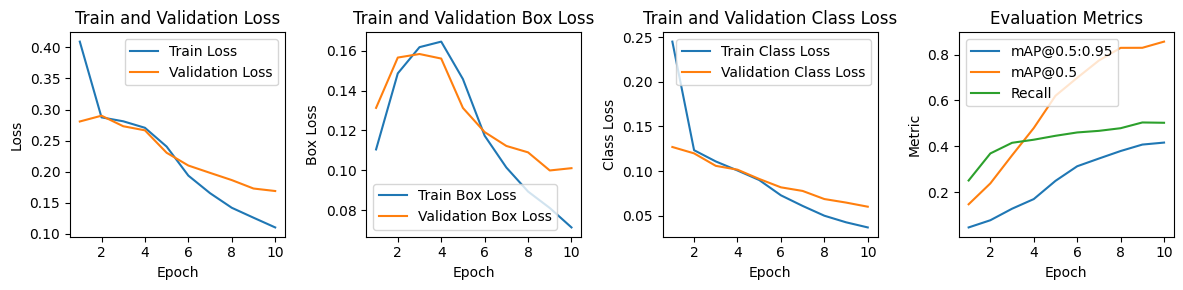

In [3]:
# 主函数
if __name__ == "__main__":
    # 加载数据集
    dataset_path = '/content/drive/MyDrive/VOC_FULL_CV'
    class_names = ['background','damage_require_restoration', 'damage_not_require_restoration','no_damage']  # 替换为实际的类名列表
    dataset = CustomDataset(dataset_path, transforms=ToTensor(), class_names=class_names)

    num_epochs = 10
    BATCH_SIZE = 16

    # 设备设置
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # 交叉验证设置
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    fold_results = {
        'train_losses': [],
        'val_losses': [],
        'train_box_losses': [],
        'train_class_losses': [],
        'val_box_losses': [],
        'val_class_losses': [],
        'recalls': [],
        'mAP_50s': [],
        'mAP_50_95s': [],
        'class_recalls': [],
        'class_mAP_50s': [],
        'class_mAP_50_95s': []
    }

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        print(f"\nFold {fold + 1}")

        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)

        # 创建数据加载器
        data_loader_train = torch.utils.data.DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)  # 设置 num_workers 为 0

        data_loader_val = torch.utils.data.DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)  # 设置 num_workers 为 0

        # 模型设置
        num_classes = len(class_names)  # 类别数量
        model = get_model(num_classes)
        model.to(device)

        # 优化器设置
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

        # 训练和评估
        fold_train_losses = []
        fold_val_losses = []
        fold_train_box_losses = []
        fold_train_class_losses = []
        fold_val_box_losses = []
        fold_val_class_losses = []
        fold_recalls = []
        fold_mAP_50s = []
        fold_mAP_50_95s = []

        for epoch in range(num_epochs):
            train_loss, train_box_loss, train_class_loss = train_one_epoch(model, optimizer, data_loader_train, device, epoch)
            val_loss, val_box_loss, val_class_loss, mAP_50_95, mAP_50, recall, class_ap_50_95, class_ap_50, class_recall = evaluate(model, data_loader_val, val_dataset, device, class_names)

            fold_train_losses.append(train_loss)
            fold_val_losses.append(val_loss)
            fold_train_box_losses.append(train_box_loss)
            fold_train_class_losses.append(train_class_loss)
            fold_val_box_losses.append(val_box_loss)
            fold_val_class_losses.append(val_class_loss)
            fold_recalls.append(recall)
            fold_mAP_50s.append(mAP_50)
            fold_mAP_50_95s.append(mAP_50_95)

            print(f"\nEpoch [{epoch + 1}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Box Loss: {train_box_loss:.4f}, Train Class Loss: {train_class_loss:.4f}, Val Box Loss: {val_box_loss:.4f}, Val Class Loss: {val_class_loss:.4f}, Recall: {recall:.4f}, mAP@0.5: {mAP_50:.4f}, mAP@0.5-0.95: {mAP_50_95:.4f}")
            for i, class_name in enumerate(class_names[1:], 1):
                print(f"\nClass: {class_name}, mAP@0.5: {class_ap_50[i-1]:.4f}, mAP@0.5:0.95: {class_ap_50_95[i-1]:.4f}, Recall: {class_recall[i-1]:.4f}")

            print('\n','-'*120,'\n')

        fold_results['train_losses'].append(fold_train_losses)
        fold_results['val_losses'].append(fold_val_losses)
        fold_results['train_box_losses'].append(fold_train_box_losses)
        fold_results['train_class_losses'].append(fold_train_class_losses)
        fold_results['val_box_losses'].append(fold_val_box_losses)
        fold_results['val_class_losses'].append(fold_val_class_losses)
        fold_results['recalls'].append(fold_recalls)
        fold_results['mAP_50s'].append(fold_mAP_50s)
        fold_results['mAP_50_95s'].append(fold_mAP_50_95s)

    print("Training completed successfully!")

    # 计算每个指标的平均值
    results = {
        'train_losses': np.mean(fold_results['train_losses'], axis=0),
        'val_losses': np.mean(fold_results['val_losses'], axis=0),
        'train_box_losses': np.mean(fold_results['train_box_losses'], axis=0),
        'train_class_losses': np.mean(fold_results['train_class_losses'], axis=0),
        'val_box_losses': np.mean(fold_results['val_box_losses'], axis=0),
        'val_class_losses': np.mean(fold_results['val_class_losses'], axis=0),
        'recalls': np.mean(fold_results['recalls'], axis=0),
        'mAP_50s': np.mean(fold_results['mAP_50s'], axis=0),
        'mAP_50_95s': np.mean(fold_results['mAP_50_95s'], axis=0)
    }

    # 保存结果
    torch.save(results, 'training_results.pth')

    # 绘制并保存结果图
    plot_results(results)

    # 打印最终的mAP@0.5, mAP@0.5:0.95和recall
    print(f"Final mAP@0.5: {results['mAP_50s'][-1]:.4f}")
    print(f"Final mAP@0.5:0.95: {results['mAP_50_95s'][-1]:.4f}")
    print(f"Final Recall: {results['recalls'][-1]:.4f}")